In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

c:\users\g50\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

In [4]:
print("Total Params:", FRmodel.count_params())

Total Params: 3743280


In [5]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss 
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    
    #  Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(anchor-positive),axis=-1)
    # Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(anchor-negative),axis=-1)
    # subtract the two previous distances and add alpha.
    basic_loss = pos_dist-neg_dist+alpha
    # Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss,0))
    
    return loss

In [6]:
with tf.Session() as test:
    tf.set_random_seed(1)
    y_true = (None, None, None)
    y_pred = (tf.random_normal([3, 128], mean=6, stddev=0.1, seed = 1),
              tf.random_normal([3, 128], mean=1, stddev=1, seed = 1),
              tf.random_normal([3, 128], mean=3, stddev=4, seed = 1))
    loss = triplet_loss(y_true, y_pred)
    
    print("loss = " + str(loss.eval()))

loss = 528.1432


In [7]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

In [35]:
database={}
key="amrit"
database.setdefault(key, [])
database[key].append(img_to_encoding("C:\\Users\\G50\\ml jupyter notebooks\\face recognition\\images\\amrit.jpg", FRmodel))
database[key].append(img_to_encoding("C:\\Users\\G50\\ml jupyter notebooks\\face recognition\\images\\test1.jpg", FRmodel))
database[key].append(img_to_encoding("C:\\Users\\G50\\ml jupyter notebooks\\face recognition\\images\\test3.jpg", FRmodel))

In [36]:

database["danielle"] = img_to_encoding("C:\\Users\\G50\\ml jupyter notebooks\\face recognition\\images\\danielle.png", FRmodel)
database["younes"] = img_to_encoding("C:\\Users\\G50\\ml jupyter notebooks\\face recognition\\images\\younes.jpg", FRmodel)
database["tian"] = img_to_encoding("C:\\Users\\G50\\ml jupyter notebooks\\face recognition\\images\\tian.jpg", FRmodel)
database["andrew"] = img_to_encoding("C:\\Users\\G50\\ml jupyter notebooks\\face recognition\\images\\andrew.jpg", FRmodel)
database["kian"] = img_to_encoding("C:\\Users\\G50\\ml jupyter notebooks\\face recognition\\images\\kian.jpg", FRmodel)
database["dan"] = img_to_encoding("C:\\Users\\G50\\ml jupyter notebooks\\face recognition\\images\\dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding("C:\\Users\\G50\\ml jupyter notebooks\\face recognition\\images\\sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding("C:\\Users\\G50\\ml jupyter notebooks\\face recognition\\images\\bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding("C:\\Users\\G50\\ml jupyter notebooks\\face recognition\\images\\kevin.jpg", FRmodel)
database["felix"] = img_to_encoding("C:\\Users\\G50\\ml jupyter notebooks\\face recognition\\images\\felix.jpg", FRmodel)
database["benoit"] = img_to_encoding("C:\\Users\\G50\\ml jupyter notebooks\\face recognition\\images\\benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding("C:\\Users\\G50\\ml jupyter notebooks\\face recognition\\images\\arnaud.jpg", FRmodel)

In [37]:
def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
    image_path -- path to an image
    identity -- string, name of the person you'd like to verify the identity. Has to be a resident of the Happy house.
    database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
    model -- your Inception model instance in Keras
    
    Returns:
    dist -- distance between the image_path and the image of "identity" in the database.
    door_open -- True, if the door should open. False otherwise.
    """
    # Step 1: Compute the encoding for the image. Use img_to_encoding() see example above. (≈ 1 line)
    encoding = img_to_encoding(image_path,model)
    mindist=10
    # Step 2: Compute distance with identity's image 
    for values in database[identity]:
        dist = np.linalg.norm((values-encoding))
        if(mindist>dist):
            mindist=dist
    if (mindist<0.7):
        print("It's " + str(identity) + ", welcome home!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
    return mindist, door_open

It's amrit, welcome home!
Tested image


c:\users\g50\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


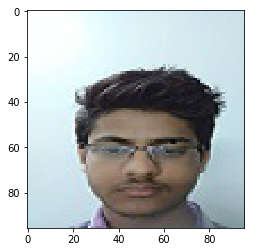

In [49]:
from pylab import *
verify("images/test2.jpg", "amrit", database, FRmodel)
print("Tested image")
image_tested = scipy.misc.imread("images/test2.jpg")
imshow(image_tested)

It's not kevin, please go away
Tested image


c:\users\g50\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


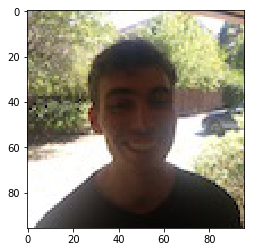

In [51]:
verify("images/camera_2.jpg", "kevin", database, FRmodel)
print("Tested image")
image_tested = scipy.misc.imread("images/camera_2.jpg")
imshow(image_tested)

In [54]:
def who_is_it(image_path, database, model):
    """
    Implements face recognition for the happy house by finding who is the person on the image_path image.
    
    Arguments:
    image_path -- path to an image
    database -- database containing image encodings along with the name of the person on the image
    model -- your Inception model instance in Keras
    
    Returns:
    min_dist -- the minimum distance between image_path encoding and the encodings from the database
    identity -- string, the name prediction for the person on image_path
    """
    
    ## Step 1: Compute the target "encoding" for the image. Use img_to_encoding() see example above. ## (≈ 1 line)
    encoding = img_to_encoding(image_path,model)
    
    ## Step 2: Find the closest encoding ##
    
    # Initialize "min_dist" to a large value, say 100 
    min_dist = 1000
    
    # Loop over the database dictionary's names and encodings.
    for (name, values) in database.items():
        for (db_enc) in values:
            
            # Compute L2 distance between the target "encoding" and the current "emb" from the database. 
            dist = np.linalg.norm(db_enc-encoding)

            # If this distance is less than the min_dist, then set min_dist to dist, and identity to name.
            if (dist<min_dist):
                min_dist = dist
                identity = name
            
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

it's younes, the distance is 0.6593845
Tested image


c:\users\g50\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


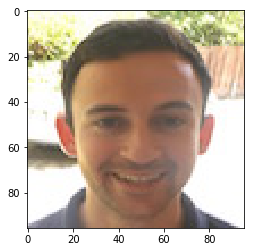

In [57]:
who_is_it("images/camera_0.jpg", database, FRmodel)
print("Tested image")
image_tested = scipy.misc.imread("images/camera_0.jpg")
imshow(image_tested)

it's amrit, the distance is 0.44386685
Tested image


c:\users\g50\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


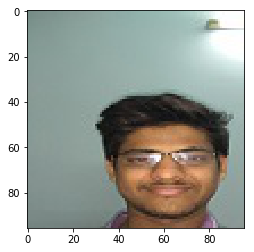

In [58]:
who_is_it("images/test5.jpg", database, FRmodel)
print("Tested image")
image_tested = scipy.misc.imread("images/test5.jpg")
imshow(image_tested)